# IMAGEN - ERROR ANALYSIS
The preliminary results in our IMAGEN paper advocates for a more in-depth understanding of what contributes to the significant performance of the ML models for the three time-points: <br>
<li>Baseline (<b>BL</b>): Age <tr> <b>14</b></li>
<li>Follow 1 year (<b>FU1</b>): Age <b>16</b></li>
<li>Follow 2 year (<b>FU2</b>): Age <b>19</b></li>
<li>Follow 3 year (<b>FU3</b>): Age <b>22</b></li>

Such in-depth understanding can be achieved by performing follow-up analysis such as: <br>

## Overview


## Error Analysis

In [1]:
################################################################################
""" IMAGEN - ERROR ANALYSIS """
# Author : JiHoon Kim, <jihoon.kim@fu-berlin.de>, 16th August 2021
#
%load_ext autoreload
%autoreload 2

import pandas as pd 
import numpy as np
from glob import glob
from os.path import join 
import os 
from scikits.bootstrap import ci
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from plotResults import *

### 1. Visualization

#### 1.1 probabilitiy distributions

In [2]:
df = pd.read_csv(sorted(glob("results/newlbls-fu3-espad-fu3-19a-binge-*/*/run.csv"))[-1])

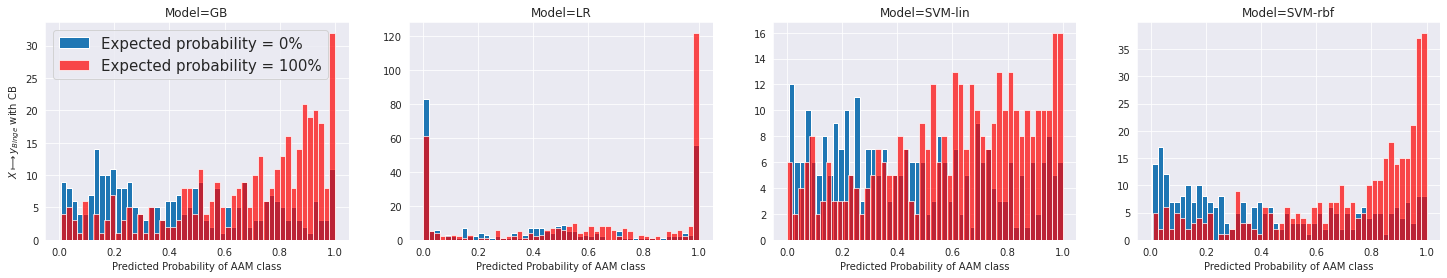

In [3]:
grp_order = ["io", "technique", "model"]
groups = df.groupby(grp_order)   
n_models = len(df["model"].unique())
n_rows = round(len(groups)/n_models)
fig, axes = plt.subplots(n_rows, n_models, 
                         sharex=True, sharey=False,
                         figsize=(25, n_models*n_rows))
axes = np.ravel(axes)
        
for i, (g, dfi) in enumerate(groups):
    ids_all = np.array([id_lists for ids in dfi["test_ids"] for id_lists in eval(ids)])
    assert ids_all.shape[0] == np.unique(ids_all).shape[0]
    probs_all = np.array([prob_lists for probs in dfi["test_probs"] for prob_lists in eval(probs)])
    y_all = np.array([y_lists for y in dfi["test_lbls"] for y_lists in eval(y)])
    assert probs_all.shape[0] == y_all.shape[0]

    prediction=probs_all[:,1]
    ax = axes[i]
    ax.hist(prediction[y_all==0], bins=50, label='Expected probability = 0%')
    ax.hist(prediction[y_all==1], bins=50, label='Expected probability = 100%', alpha=0.7, color='r')
    ax.set_xlabel('Predicted Probability of AAM class')
    if i%n_models == 0:
        ax.set_ylabel("{} with {}".format(remap_io(dfi.iloc[0]), g[1].upper()))
    if i == 0:
        ax.legend(fontsize=15)
    ax.set_title("Model={}".format(g[-1]))
    
plt.show()

### 2. Performance across sites

#### 2.1 main experiment

In [4]:
df = pd.read_csv(sorted(glob("results/newlbls-fu3-espad-fu3-19a-binge-*/*/run.csv"))[-1])

In [5]:
test_id = sum([df['test_ids'][i].strip('][').split(', ') for i in range(28)], [])
test_probs = np.array([prob_lists for probs in df["test_probs"] for prob_lists in eval(probs)])[:,1]
test_lbls = sum([df['test_lbls'][i].strip('][').split(', ') for i in range(28)], [])
model = [g for (g, dfi) in df.groupby(["i", "o", "technique", "model"])]
test_model = []

for i in range(len(test_id)):
    if i < 650:
        test_model.append(model[0])
    elif (i >= 650) & (i < 1300):
        test_model.append(model[1])
    elif (i >= 1300) & (i < 1950):
        test_model.append(model[2])
    else:
        test_model.append(model[3])

df2 = pd.DataFrame({
    "ID" : test_id,
    "Model" : test_model,
    "Probability" : test_probs, 
    "Labels" : test_lbls,})
DF = df2.astype({"ID":'int', "Probability":'float', "Labels":'float'})

DF.to_csv('newlbls-fu3-espad-fu3-19a-binge-n650_run.csv')

In [6]:
df_GB = DF.loc[range(0,650), :]
df_LR = DF.loc[range(650,1300), :]
df_LIN = DF.loc[range(1300,1950), :]
df_RBF = DF.loc[range(1950,2600), :]

df_T_GB = df_GB[((df_GB['Labels'] == 1.0) & (df_GB['Probability'] >= 0.5) | (df_GB['Labels'] == 0.0) & (df_GB['Probability'] < 0.5))]
df_TP_GB = df_GB[(df_GB['Labels'] == 1.0) & (df_GB['Probability'] >= 0.5)]
df_TN_GB = df_GB[(df_GB['Labels'] == 0.0) & (df_GB['Probability'] < 0.5)]
df_F_GB = df_GB[((df_GB['Labels'] == 0.0) & (df_GB['Probability'] >= 0.5) | (df_GB['Labels'] == 1.0) & (df_GB['Probability'] < 0.5))]
df_FP_GB = df_GB[(df_GB['Labels'] == 0.0) & (df_GB['Probability'] >= 0.5)]
df_FN_GB = df_GB[(df_GB['Labels'] == 1.0) & (df_GB['Probability'] < 0.5)]

print(len(df_T_GB), len(df_TP_GB), len(df_TN_GB), len(df_F_GB), len(df_FP_GB), len(df_FN_GB))

453 284 169 197 113 84


In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, \
                            recall_score, precision_score, f1_score
from sklearn.metrics import classification_report

y_true = df_GB['Labels'].to_list()
y_pred = np.round(df_GB['Probability'].to_list())
# Confusion Matrix
print('confusion matrix \n', confusion_matrix(y_true, y_pred))
# Accuracy
print('accuracy score \n', accuracy_score(y_true, y_pred))
# Recall
print('recall score \n', recall_score(y_true, y_pred, average=None))
# Precision
print('precision score \n', precision_score(y_true, y_pred, average=None))
# Method 1: sklearn
print('f1_score \n', f1_score(y_true, y_pred, average=None))
print(classification_report(y_true, y_pred, target_names=['HC', 'AAM']))

confusion matrix 
 [[169 113]
 [ 84 284]]
accuracy score 
 0.696923076923077
recall score 
 [0.59929078 0.77173913]
precision score 
 [0.66798419 0.71536524]
f1_score 
 [0.6317757  0.74248366]
              precision    recall  f1-score   support

          HC       0.67      0.60      0.63       282
         AAM       0.72      0.77      0.74       368

    accuracy                           0.70       650
   macro avg       0.69      0.69      0.69       650
weighted avg       0.69      0.70      0.69       650



In [8]:
################################################################################
from imagen_instrumentloader import *
from imagen_plot_statistics import *
# DATA_DIR = '/ritter/share/data/IMAGEN'

In [9]:
import joypy
%matplotlib inline

In [10]:
binge_FU3_NEO = IMAGEN_instrument()
df_binge_FU3_NEO, col_binge_FU3_NEO = binge_FU3_NEO.to_instrument(
    "newlbls-fu3-espad-fu3-19a-binge-n650.h5", # h5files
    "FU3",                                     # session
    "IMAGEN-IMGN_NEO_FFI_FU3.csv",             # instrument
    "NEO",                                     # roi name
    save = False,                               # save
    viz = False)                                # summary

# binge_FU3_NEO = IMAGEN_quick()
# df_binge_FU3_NEO, col_binge_FU3_NEO = binge_FU3_NEO.to_instrument(
#     "newlbls-fu3-espad-fu3-19a-binge-n650_FU3_NEO.csv", # instrument
#     viz = True)                                         # summary

---------- Neuroticism mean
ShapiroResult(statistic=0.9844947457313538, pvalue=0.0005509337643161416) ShapiroResult(statistic=0.9916834235191345, pvalue=0.11304288357496262)
LeveneResult(statistic=1.6915659646719141, pvalue=0.1938570071253325)
BartlettResult(statistic=0.8693549956966128, pvalue=0.3511339349823773)
Ttest_indResult(statistic=-0.13560394867758788, pvalue=0.8921764963743465)
Ttest_indResult(statistic=-0.13654859899894203, pvalue=0.8914319809627931)
---------- Extroversion mean
ShapiroResult(statistic=0.9840741157531738, pvalue=0.00043959004688076675) ShapiroResult(statistic=0.9936059713363647, pvalue=0.27583783864974976)
LeveneResult(statistic=3.1694971639760157, pvalue=0.07549400757899889)
BartlettResult(statistic=1.4919151770823909, pvalue=0.22191954692719826)
Ttest_indResult(statistic=5.326249811794161, pvalue=1.3846542285027802e-07)
Ttest_indResult(statistic=5.278308423009785, pvalue=1.842314683158053e-07)
---------- Openness mean
ShapiroResult(statistic=0.990659415721

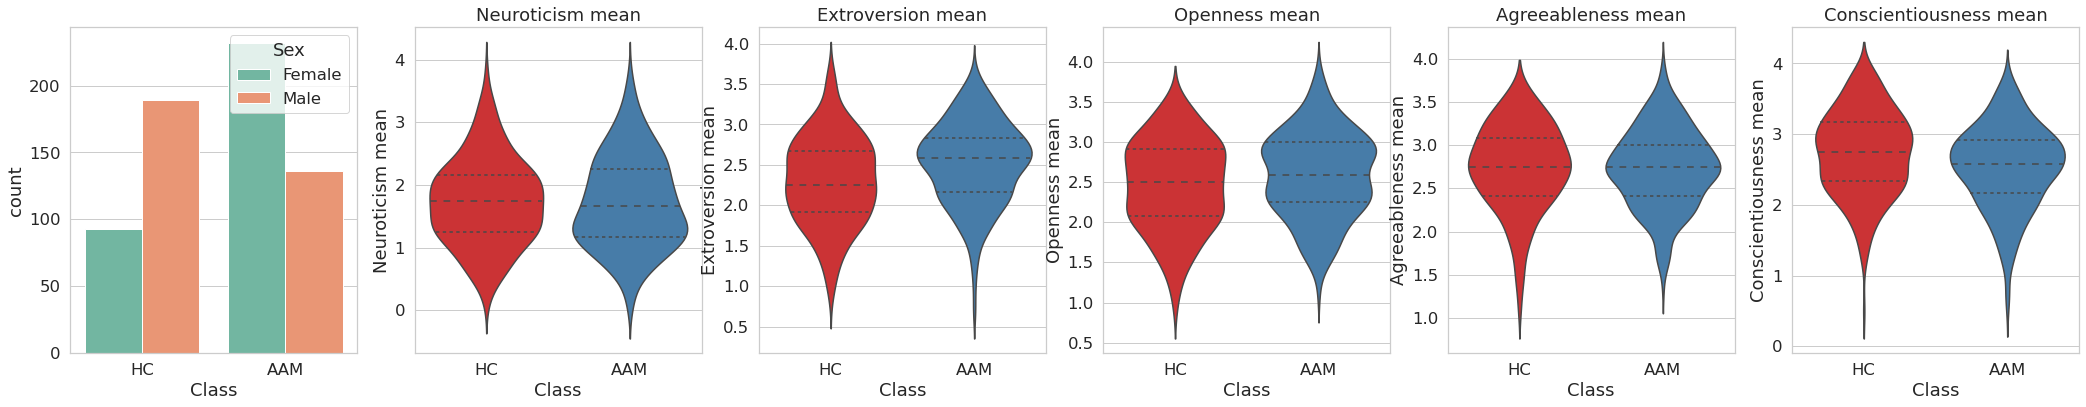

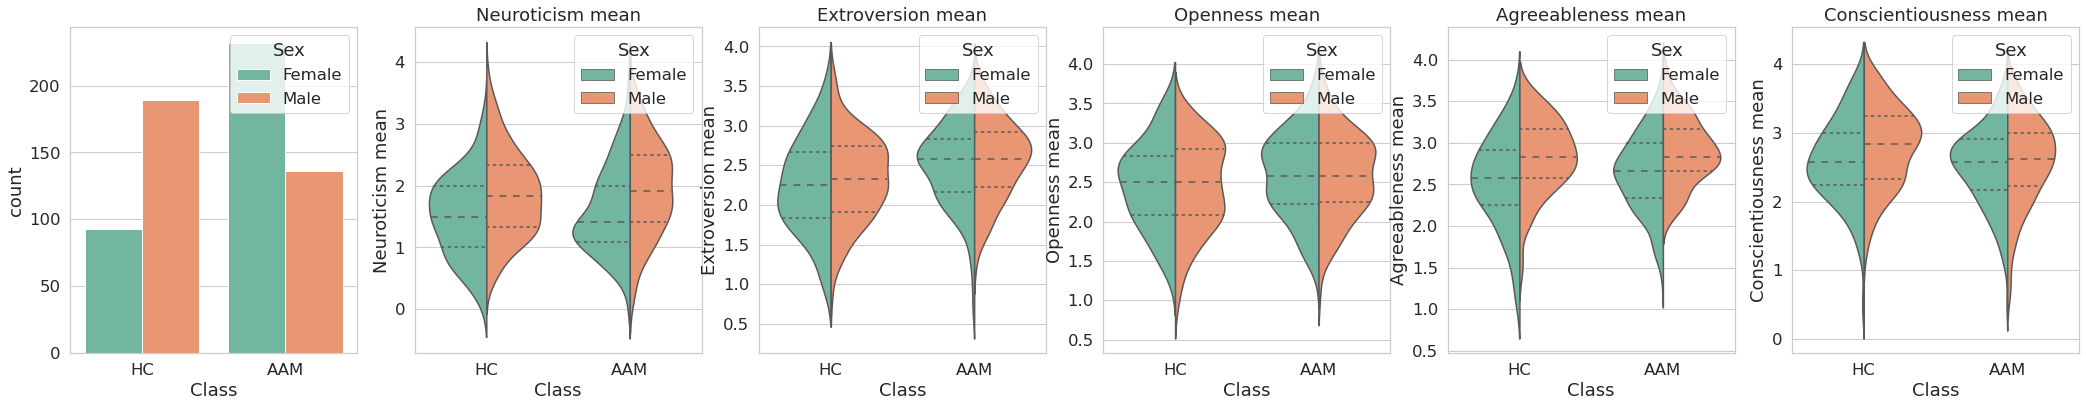

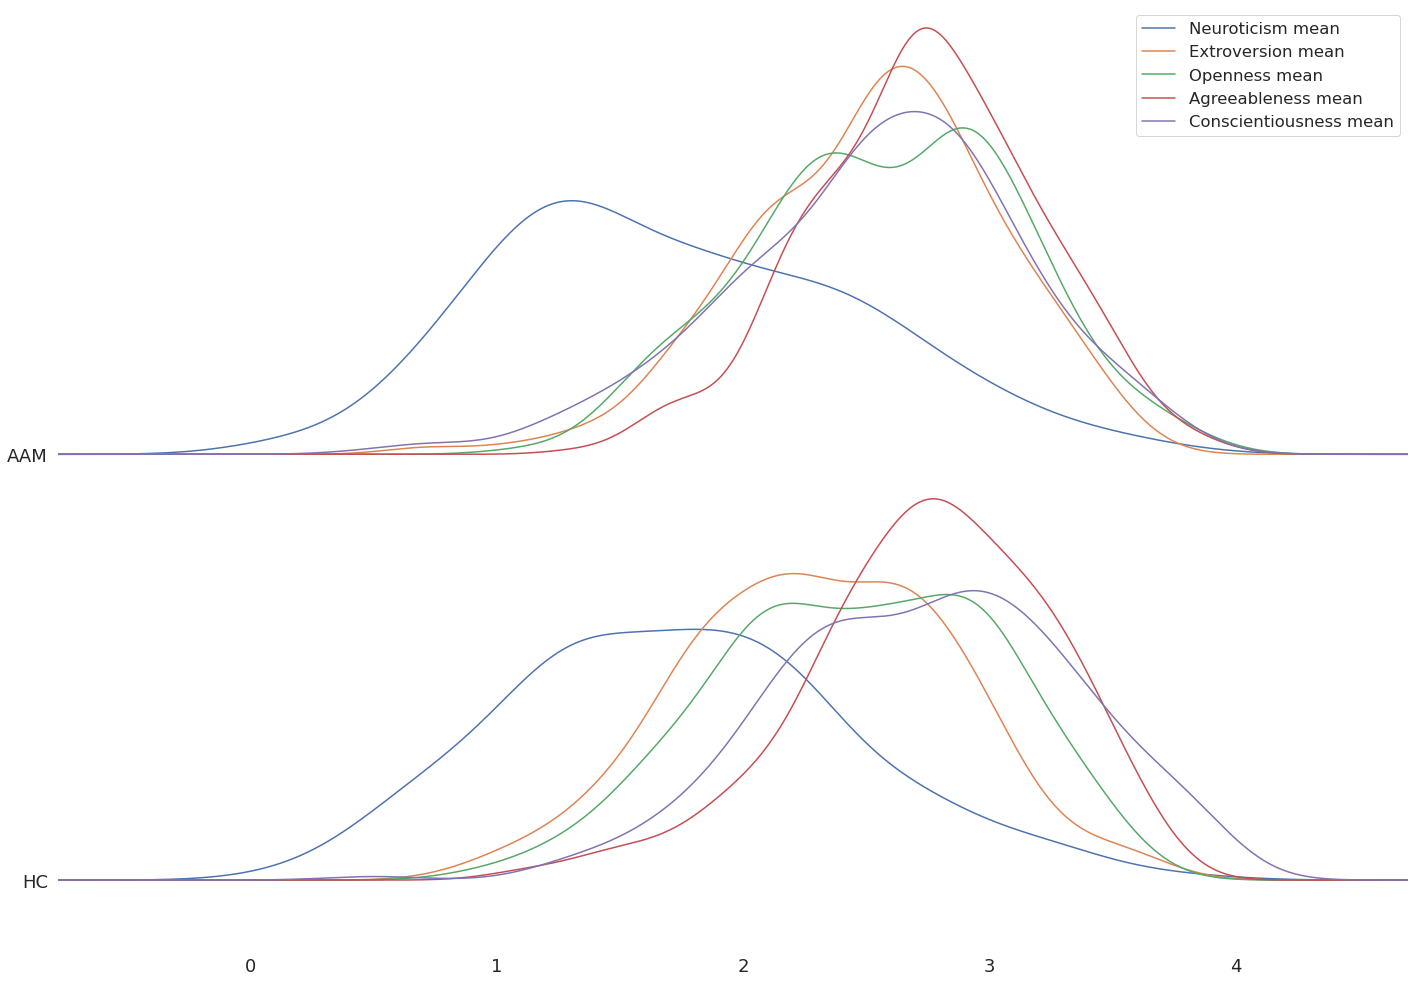

In [11]:
DF = df_binge_FU3_NEO
COL = col_binge_FU3_NEO

plot_binge_FU3_NEO = IMAGEN_descriptive(DF, COL)
plot_binge_FU3_NEO.violinplot()
fig, axes = joypy.joyplot(DF, by='Class', fill=False, figsize = (20, 14), legend=True)
# Normality Test and Independent T test
from scipy.stats import shapiro, levene, ttest_ind, bartlett
for mean in COL[:-3]:
    print("-"*10, mean)
    myAAM = list(DF[DF['Class'] == 'AAM'][mean].values)
    AAM = [x for x in myAAM if pd.isnull(x) == False]
    myHC = list(DF[DF['Class'] == 'HC'][mean].values)    
    HC = [x for x in myHC if pd.isnull(x) == False]
    
    # Shapiro-Wilks
    normal1 = shapiro(AAM)
    normal2 = shapiro(HC)
    print(normal1, normal2)
    # Levene test
    print(levene(AAM, HC))
    # bartlett test
    print(bartlett(AAM, HC))
    # ttest
    print(ttest_ind(AAM, HC))
    print(ttest_ind(AAM, HC, equal_var=False))

---------- Neuroticism mean
ShapiroResult(statistic=0.9814513325691223, pvalue=0.0009562823688611388) ShapiroResult(statistic=0.9879186153411865, pvalue=0.15604902803897858)
LeveneResult(statistic=3.7220829174460355, pvalue=0.05432438419785351)
BartlettResult(statistic=2.0225977470513246, pvalue=0.15497382014162908)
Ttest_indResult(statistic=0.21895575396848158, pvalue=0.8267835662655134)
Ttest_indResult(statistic=0.22452118558230796, pvalue=0.8224721184350952)
---------- Extroversion mean
ShapiroResult(statistic=0.9817055463790894, pvalue=0.0010660792468115687) ShapiroResult(statistic=0.991533637046814, pvalue=0.42084383964538574)
LeveneResult(statistic=0.02128072105780353, pvalue=0.8840819834379706)
BartlettResult(statistic=0.3051780332624365, pvalue=0.58065432174237)
Ttest_indResult(statistic=3.6050593559436854, pvalue=0.0003468877379691381)
Ttest_indResult(statistic=3.6402692060188673, pvalue=0.00031178657387495606)
---------- Openness mean
ShapiroResult(statistic=0.989953637123107

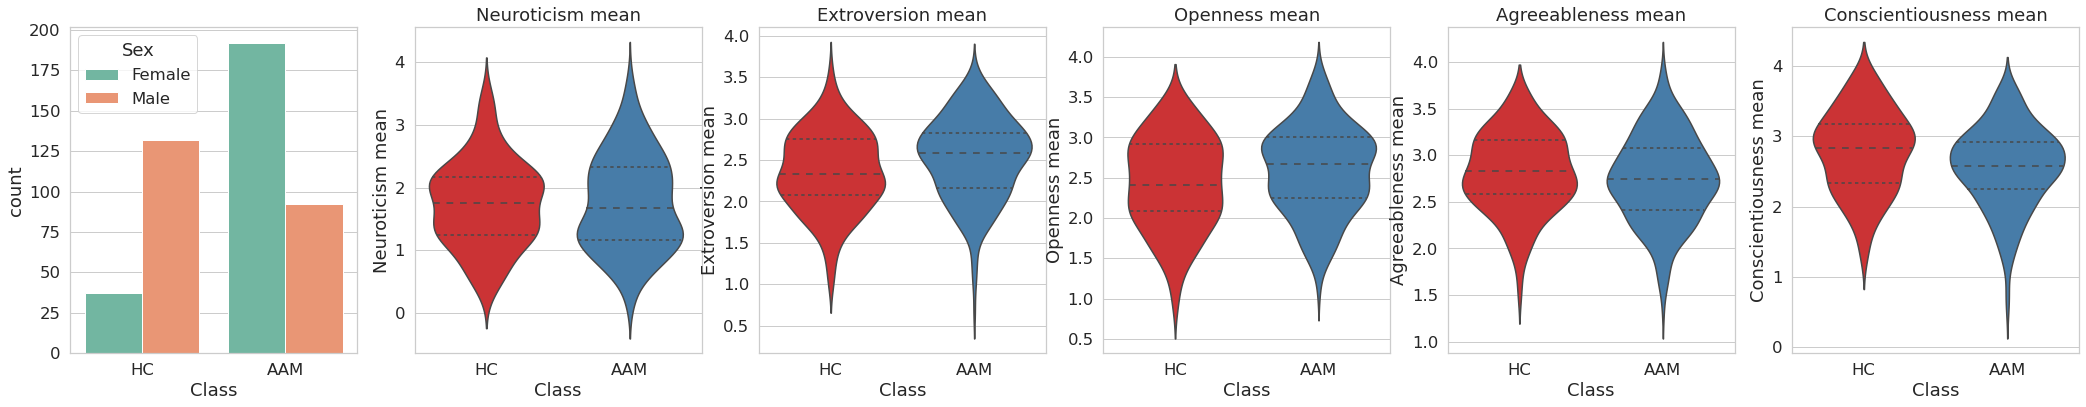

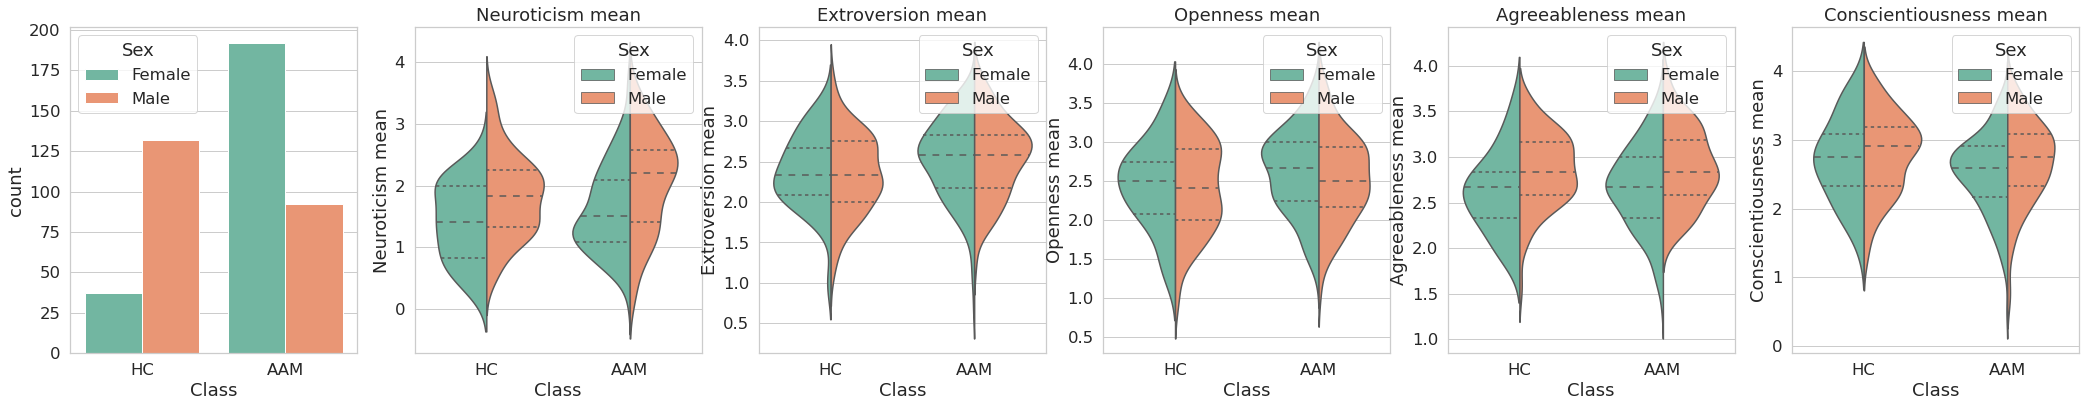

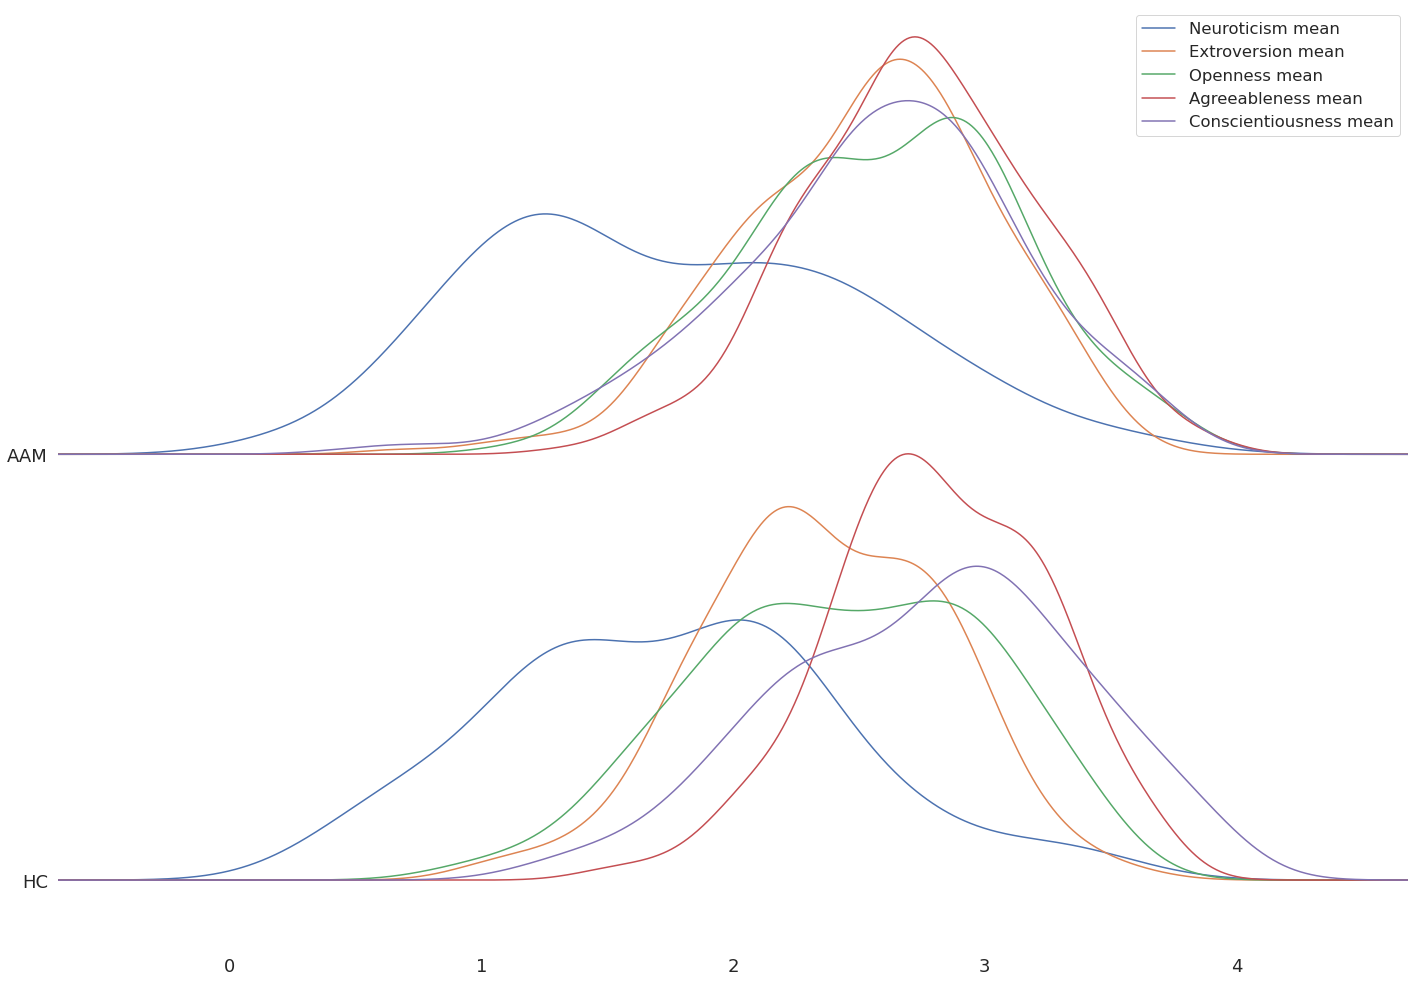

In [12]:
DF = df_binge_FU3_NEO.loc[df_T_GB['ID'].to_list(), :]
COL = col_binge_FU3_NEO

plot_binge_FU3_NEO = IMAGEN_descriptive(DF, COL)
plot_binge_FU3_NEO.violinplot()
fig, axes = joypy.joyplot(DF, by='Class', fill=False, figsize = (20, 14), legend=True)
# Normality Test and Independent T test
from scipy.stats import shapiro, levene, ttest_ind, bartlett
for mean in COL[:-3]:
    print("-"*10, mean)
    myAAM = list(DF[DF['Class'] == 'AAM'][mean].values)
    AAM = [x for x in myAAM if pd.isnull(x) == False]
    myHC = list(DF[DF['Class'] == 'HC'][mean].values)    
    HC = [x for x in myHC if pd.isnull(x) == False]
    
    # Shapiro-Wilks
    normal1 = shapiro(AAM)
    normal2 = shapiro(HC)
    print(normal1, normal2)
    # Levene test
    print(levene(AAM, HC))
    # bartlett test
    print(bartlett(AAM, HC))
    # ttest
    print(ttest_ind(AAM, HC))
    print(ttest_ind(AAM, HC, equal_var=False))

---------- Neuroticism mean
ShapiroResult(statistic=0.9830278158187866, pvalue=0.3359200656414032) ShapiroResult(statistic=0.9872633814811707, pvalue=0.3665138781070709)
LeveneResult(statistic=1.7838804655177987, pvalue=0.18323037800209221)
BartlettResult(statistic=1.5149579885824247, pvalue=0.21838409728279715)
Ttest_indResult(statistic=-1.0109496528931101, pvalue=0.31329329360218466)
Ttest_indResult(statistic=-1.0300756187383535, pvalue=0.30428795471714054)
---------- Extroversion mean
ShapiroResult(statistic=0.9842473864555359, pvalue=0.3975129723548889) ShapiroResult(statistic=0.9851121306419373, pvalue=0.24521379172801971)
LeveneResult(statistic=3.781250771854156, pvalue=0.05326830393300545)
BartlettResult(statistic=1.470588576251938, pvalue=0.2252528525917762)
Ttest_indResult(statistic=3.3828086399673007, pvalue=0.0008670725665130574)
Ttest_indResult(statistic=3.445856079496881, pvalue=0.0007011548868458972)
---------- Openness mean
ShapiroResult(statistic=0.9792143106460571, pva

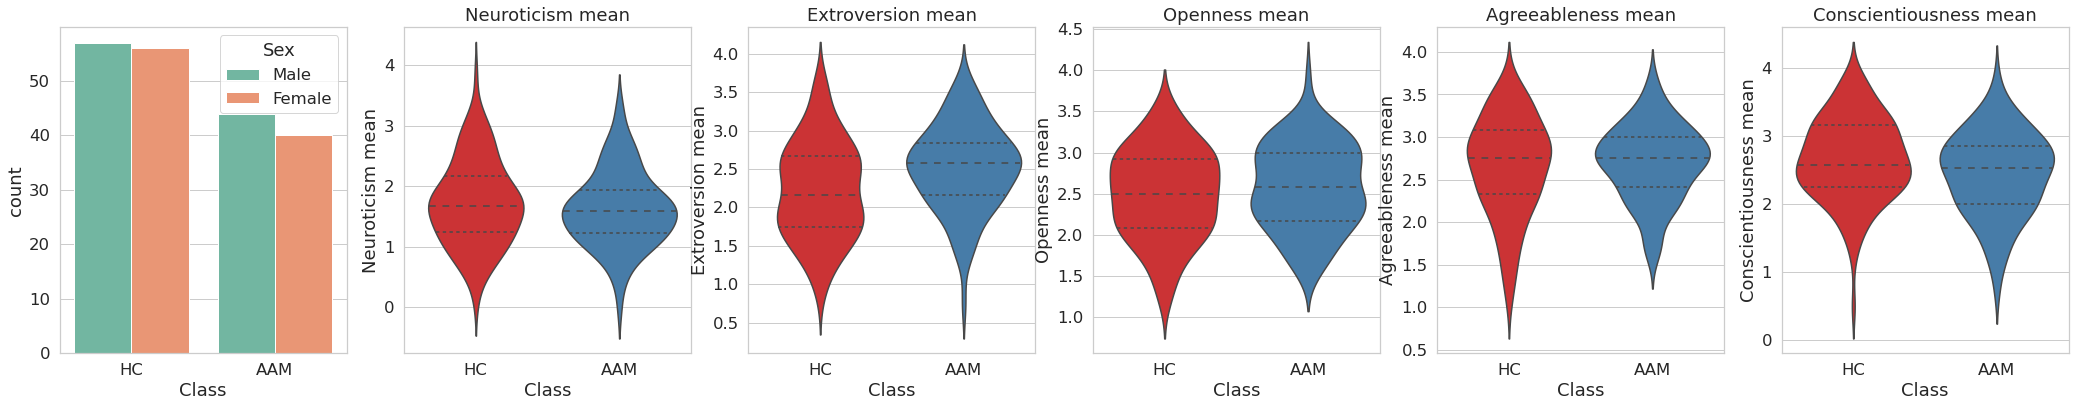

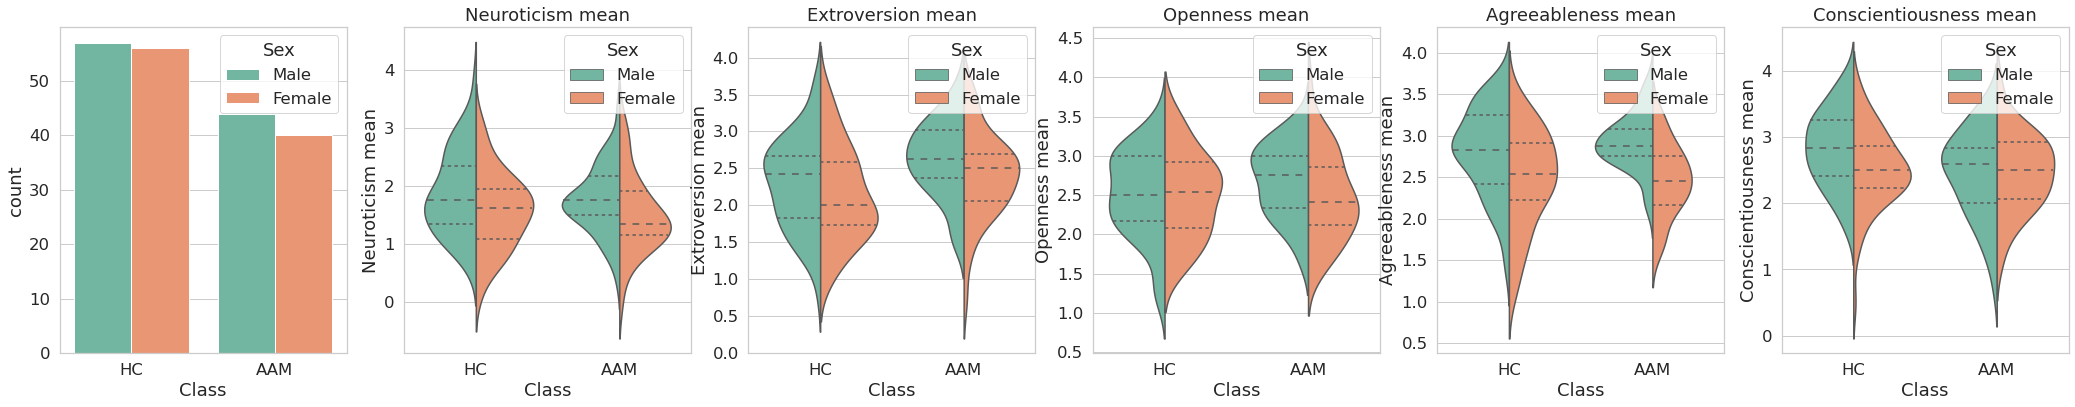

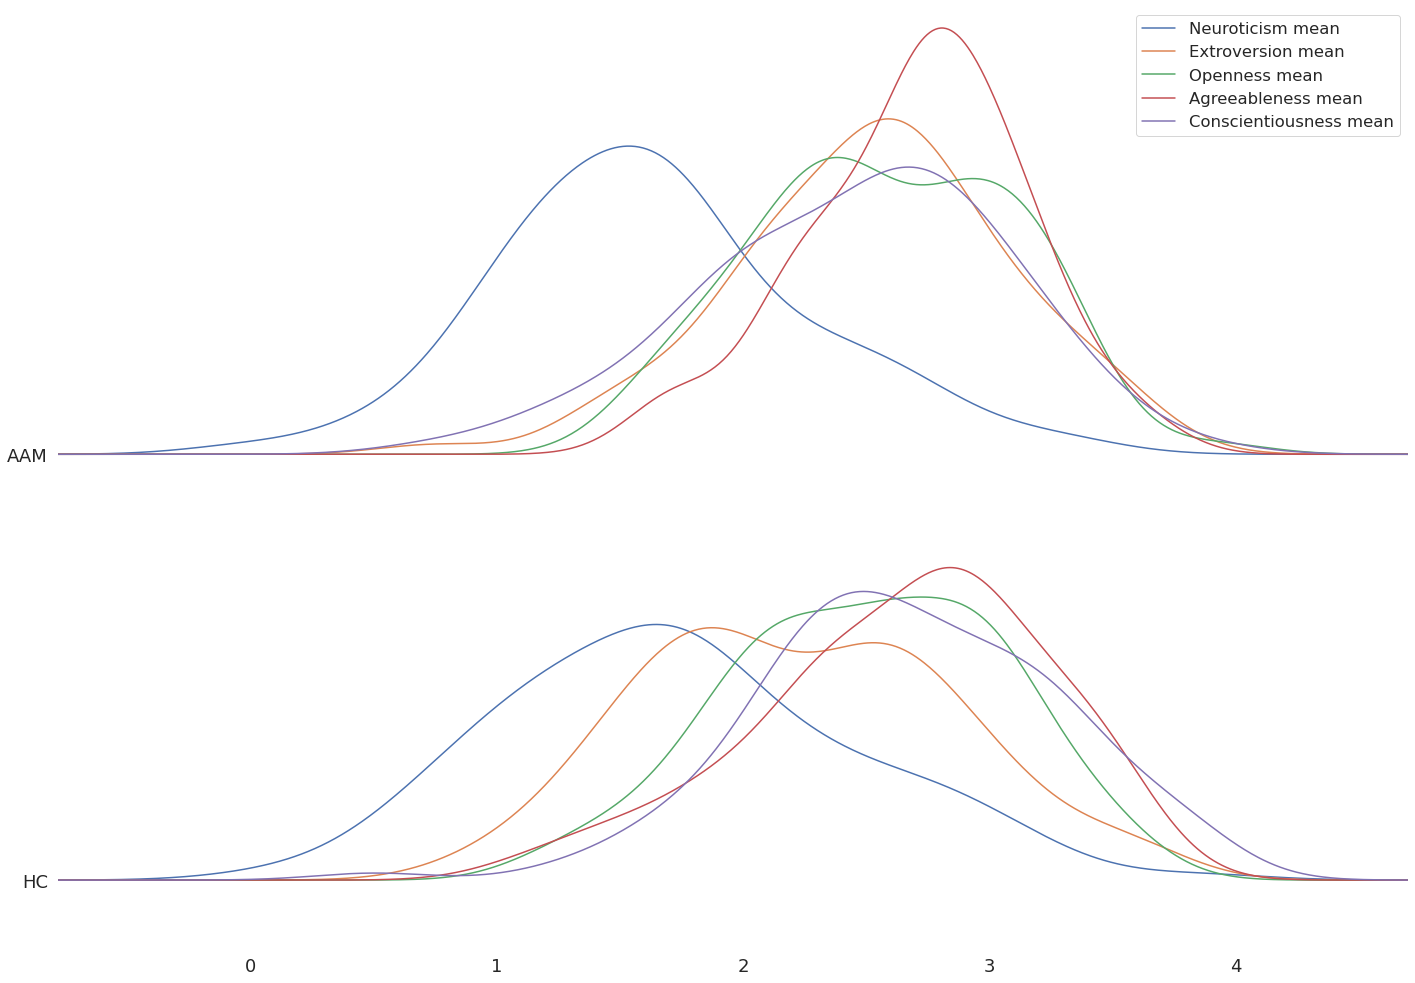

In [13]:
DF = df_binge_FU3_NEO.loc[df_F_GB['ID'].to_list(), :]
COL = col_binge_FU3_NEO

plot_binge_FU3_NEO = IMAGEN_descriptive(DF, COL)
plot_binge_FU3_NEO.violinplot()
fig, axes = joypy.joyplot(DF, by='Class', fill=False, figsize = (20, 14), legend=True)
# Normality Test and Independent T test
from scipy.stats import shapiro, levene, ttest_ind, bartlett
for mean in COL[:-3]:
    print("-"*10, mean)
    myAAM = list(DF[DF['Class'] == 'AAM'][mean].values)
    AAM = [x for x in myAAM if pd.isnull(x) == False]
    myHC = list(DF[DF['Class'] == 'HC'][mean].values)    
    HC = [x for x in myHC if pd.isnull(x) == False]
    
    # Shapiro-Wilks
    normal1 = shapiro(AAM)
    normal2 = shapiro(HC)
    print(normal1, normal2)
    # Levene test
    print(levene(AAM, HC))
    # bartlett test
    print(bartlett(AAM, HC))
    # ttest
    print(ttest_ind(AAM, HC))
    print(ttest_ind(AAM, HC, equal_var=False))

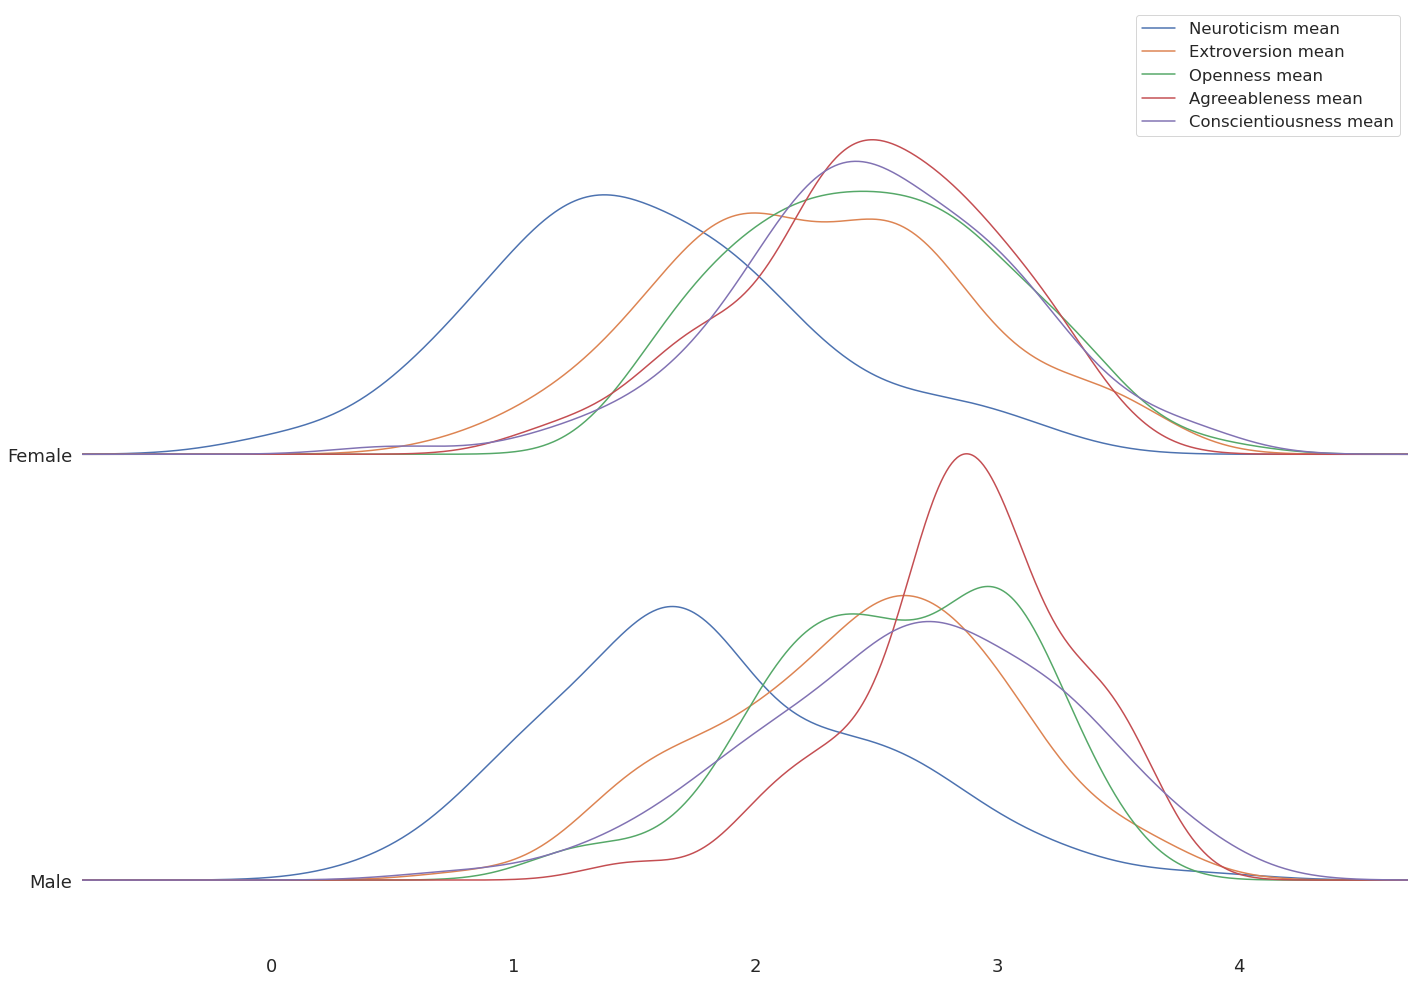

In [14]:
fig, axes = joypy.joyplot(DF, by='Sex', fill=False, figsize = (20, 14), legend=True)